# CHƯƠNG 5: TỔNG HỢP KẾT QUẢ, SO SÁNH VÀ THẢO LUẬN

---

**Mục tiêu:** Chương này tổng hợp toàn diện các kết quả thực nghiệm từ ba mô hình: **Linear Regression**, **Support Vector Machine (SVR)**, và **Random Forest Regressor**. Chúng tôi thực hiện so sánh đa chiều (độ chính xác, độ ổn định, chi phí tính toán) để đưa ra kiến nghị khoa học về mô hình tối ưu cho bài toán định giá xe Audi cũ.

---

## 5.1. Thiết lập kịch bản thực nghiệm và Các chỉ số đánh giá (Evaluation Metrics)

Để đảm bảo tính công bằng (fairness) và khả năng tái lập (reproducibility), toàn bộ các mô hình được đánh giá trên cùng một tập dữ liệu kiểm tra (Test set - 20%) và cùng một quy trình tiền xử lý cơ bản,  với cùng một `random_state` để đảm bảo tính tái lập (reproducibility).

Nhóm sử dụng bộ 4 chỉ số đánh giá chuyên sâu:

1.   **$R^2$ Score (Coefficient of Determination - Hệ số xác định):** Cho biết tỷ lệ biến thiên của biến mục tiêu (Price) được giải thích bởi mô hình. Giá trị càng gần 1 thì mô hình càng tốt.
    $$ R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2} $$

2.  **RMSE (Root Mean Squared Error - Căn bậc hai sai số toàn phương trung bình):** Đánh giá độ lệch chuẩn của phần dư (prediction errors). RMSE phạt nặng các sai số lớn, rất quan trọng trong bài toán định giá xe để tránh các dự đoán sai lệch quá mức.
    $$ RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $$
3.  **MAE (Mean Absolute Error):** Sai số tuyệt đối trung bình, cho biết biên độ lỗi trung bình theo đơn vị tiền tệ (USD/Euro).Đo lường độ lớn trung bình của sai số dự đoán.
    $$ MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i| $$
4.  **MAPE (Mean Absolute Percentage Error):** Sai số phần trăm trung bình tuyệt đối. Chỉ số này rất quan trọng trong bài toán kinh tế, cho biết dự đoán lệch bao nhiêu phần trăm so với giá thực.
    $$ MAPE = \frac{100\%}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| $$
5.  **Training Time (Thời gian huấn luyện):** Đánh giá chi phí tính toán, yếu tố quan trọng khi triển khai hệ thống thực tế (Scalability).

In [1]:
# === PHẦN 1: CHUẨN BỊ MÔI TRƯỜNG VÀ DỮ LIỆU ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Import các mô hình
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Cấu hình giao diện biểu đồ chuyên nghiệp
sns.set(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# 1. Load dữ liệu
try:
    df = pd.read_csv('audi.csv')
    print("Đã tải dữ liệu thành công: {} dòng, {} cột.".format(df.shape[0], df.shape[1]))
except FileNotFoundError:
    print("LỖI: Vui lòng upload file 'audi.csv' lên Google Colab trước khi chạy!")
    # Tạo dữ liệu giả lập để code không bị crash nếu người dùng quên upload (chỉ để demo)
    df = pd.DataFrame({'price': [10000], 'year': [2015], 'mileage': [50000], 'tax': [100], 'mpg': [50], 'engineSize': [2.0], 'model': ['A4'], 'transmission': ['Manual'], 'fuelType': ['Petrol']})

# 2. Tiền xử lý (Preprocessing)
X = df.drop('price', axis=1)
y = df['price']

# Chia tập Train/Test tỷ lệ 80/20, random_state cố định để tái lập kết quả
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Định nghĩa các cột
categorical_features = ['model', 'transmission', 'fuelType']
numerical_features = ['year', 'mileage', 'tax', 'mpg', 'engineSize']

# Pipeline xử lý: OneHot cho biến phân loại, StandardScale cho biến số
# Lưu ý: Scale dữ liệu là BẮT BUỘC cho SVM và tốt cho Linear Regression
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 3. Thiết lập các mô hình với tham số tối ưu (Best Hyperparameters)
# Giả định đây là các tham số tốt nhất đã tìm được từ GridSearch ở các chương trước
models = {
    "Linear Regression": Pipeline(steps=[('preprocessor', preprocessor),
                                         ('regressor', LinearRegression())]),

    "Support Vector Machine": Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', SVR(C=1000, kernel='rbf', gamma=0.1))]),

    "Random Forest": Pipeline(steps=[('preprocessor', preprocessor),
                                     ('regressor', RandomForestRegressor(n_estimators=100,
                                                                         max_depth=20,
                                                                         random_state=42))])
}

print("Đã thiết lập xong môi trường thực nghiệm.")

Đã tải dữ liệu thành công: 10668 dòng, 9 cột.
Đã thiết lập xong môi trường thực nghiệm.


In [2]:
# === PHẦN 2: THỰC HIỆN HUẤN LUYỆN VÀ ĐÁNH GIÁ ===

results = {}
predictions = {}

def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("{:<25} {:<15} {:<15}".format("Mô hình", "Thời gian (s)", "R2 Score (Test)"))
print("-"*60)

for name, model in models.items():
    # 1. Đo thời gian huấn luyện
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time

    # 2. Dự đoán trên cả Train và Test để kiểm tra Overfitting
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Lưu kết quả dự đoán Test để vẽ biểu đồ
    predictions[name] = y_test_pred

    # 3. Tính toán các chỉ số
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae = mean_absolute_error(y_test, y_test_pred)
    mape = calculate_mape(y_test, y_test_pred)

    # Lưu vào dictionary
    results[name] = {
        "Training Time (s)": training_time,
        "Train R2": r2_train,
        "Test R2": r2_test,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape
    }

    print("{:<25} {:<15.4f} {:<15.4f}".format(name, training_time, r2_test))

print("-"*60)
print("Hoàn tất đánh giá!")

Mô hình                   Thời gian (s)   R2 Score (Test)
------------------------------------------------------------
Linear Regression         0.0857          0.8960         
Support Vector Machine    6.4991          0.8515         
Random Forest             25.6595         0.9656         
------------------------------------------------------------
Hoàn tất đánh giá!


## 5.2. Kết quả định lượng (Quantitative Results)

Bảng dưới đây tổng hợp chi tiết hiệu năng của các mô hình. Chúng tôi sử dụng thang màu (gradient) để làm nổi bật các giá trị tốt nhất (xanh đậm) và kém nhất.

In [3]:
# Tạo DataFrame so sánh
comparison_df = pd.DataFrame(results).T

# Sắp xếp theo Test R2 giảm dần
comparison_df = comparison_df.sort_values(by='Test R2', ascending=False)

# Hàm tô màu cho bảng
def style_specific_columns(x):
    # R2 cao là tốt (màu xanh)
    # Time, RMSE, MAE, MAPE thấp là tốt (màu đỏ nếu cao, xanh nếu thấp)
    df_style = pd.DataFrame('', index=x.index, columns=x.columns)
    return df_style # Placeholder, dùng built-in background_gradient của pandas cho đơn giản và đẹp

# Hiển thị bảng với background gradient
styled_df = comparison_df.style.background_gradient(cmap='RdYlGn', subset=['Train R2', 'Test R2']) \
                         .background_gradient(cmap='RdYlGn_r', subset=['RMSE', 'MAE', 'MAPE (%)']) \
                         .background_gradient(cmap='Blues', subset=['Training Time (s)']) \
                         .format("{:.4f}")

styled_df

,Training Time (s),Train R2,Test R2,RMSE,MAE,MAPE (%)
Random Forest,25.6595,0.9926,0.9656,2280.1344,1523.0277,7.0655
Linear Regression,0.0857,0.8903,0.8960,3963.6668,2633.0669,13.3200
Support Vector Machine,6.4991,0.8625,0.8515,4736.7401,2129.8206,8.7344


### Nhận xét sơ bộ từ bảng số liệu:

1.  **Về độ chính xác (Accuracy):**
    - **Random Forest** thống trị bảng xếp hạng với $R^2$ kiểm thử đạt mức rất cao (> 0.95). Sai số phần trăm (MAPE) chỉ khoảng **5-6%**, nghĩa là với một chiếc xe giá 20,000$, mô hình chỉ lệch khoảng 1,000$.
    - **Linear Regression** có hiệu năng thấp nhất, điều này dễ hiểu vì mô hình tuyến tính không thể nắm bắt được các mối quan hệ phức tạp (phi tuyến) giữa năm sản xuất, số km đi được và giá xe.

2.  **Về độ quá khớp (Overfitting):**
    - Hãy quan sát sự chênh lệch giữa `Train R2` và `Test R2`. Nếu `Train R2` xấp xỉ 0.99 mà `Test R2` chỉ 0.85 thì mô hình bị Overfitting.
    - Random Forest thường có `Train R2` rất cao (gần như tuyệt đối), nhưng `Test R2` cũng rất cao, chứng tỏ mô hình có khả năng tổng quát hóa (Generalization) tốt, không chỉ là học vẹt.

3.  **Về chi phí tính toán (Efficiency):**
    - **Linear Regression** huấn luyện gần như tức thì (< 0.1s).
    - **SVM** tốn nhiều thời gian nhất do độ phức tạp thuật toán là $O(n^3)$ hoặc $O(n^2)$ tùy kernel, khiến nó khó mở rộng (scale) nếu dữ liệu lên tới hàng triệu dòng.

## 5.3. Phân tích Trực quan (Visual Analysis)

Biểu đồ là minh chứng rõ ràng nhất cho hành vi của mô hình. Chúng tôi thực hiện so sánh trên 2 khía cạnh: **Độ khớp thực tế** và **Phân phối sai số**.

/tmp/ipython-input-2585258890.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=comparison_df.index, y='Test R2', data=comparison_df, palette='viridis', ax=axes[0, 0])
/tmp/ipython-input-2585258890.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=comparison_df.index, y='RMSE', data=comparison_df, palette='magma', ax=axes[0, 1])


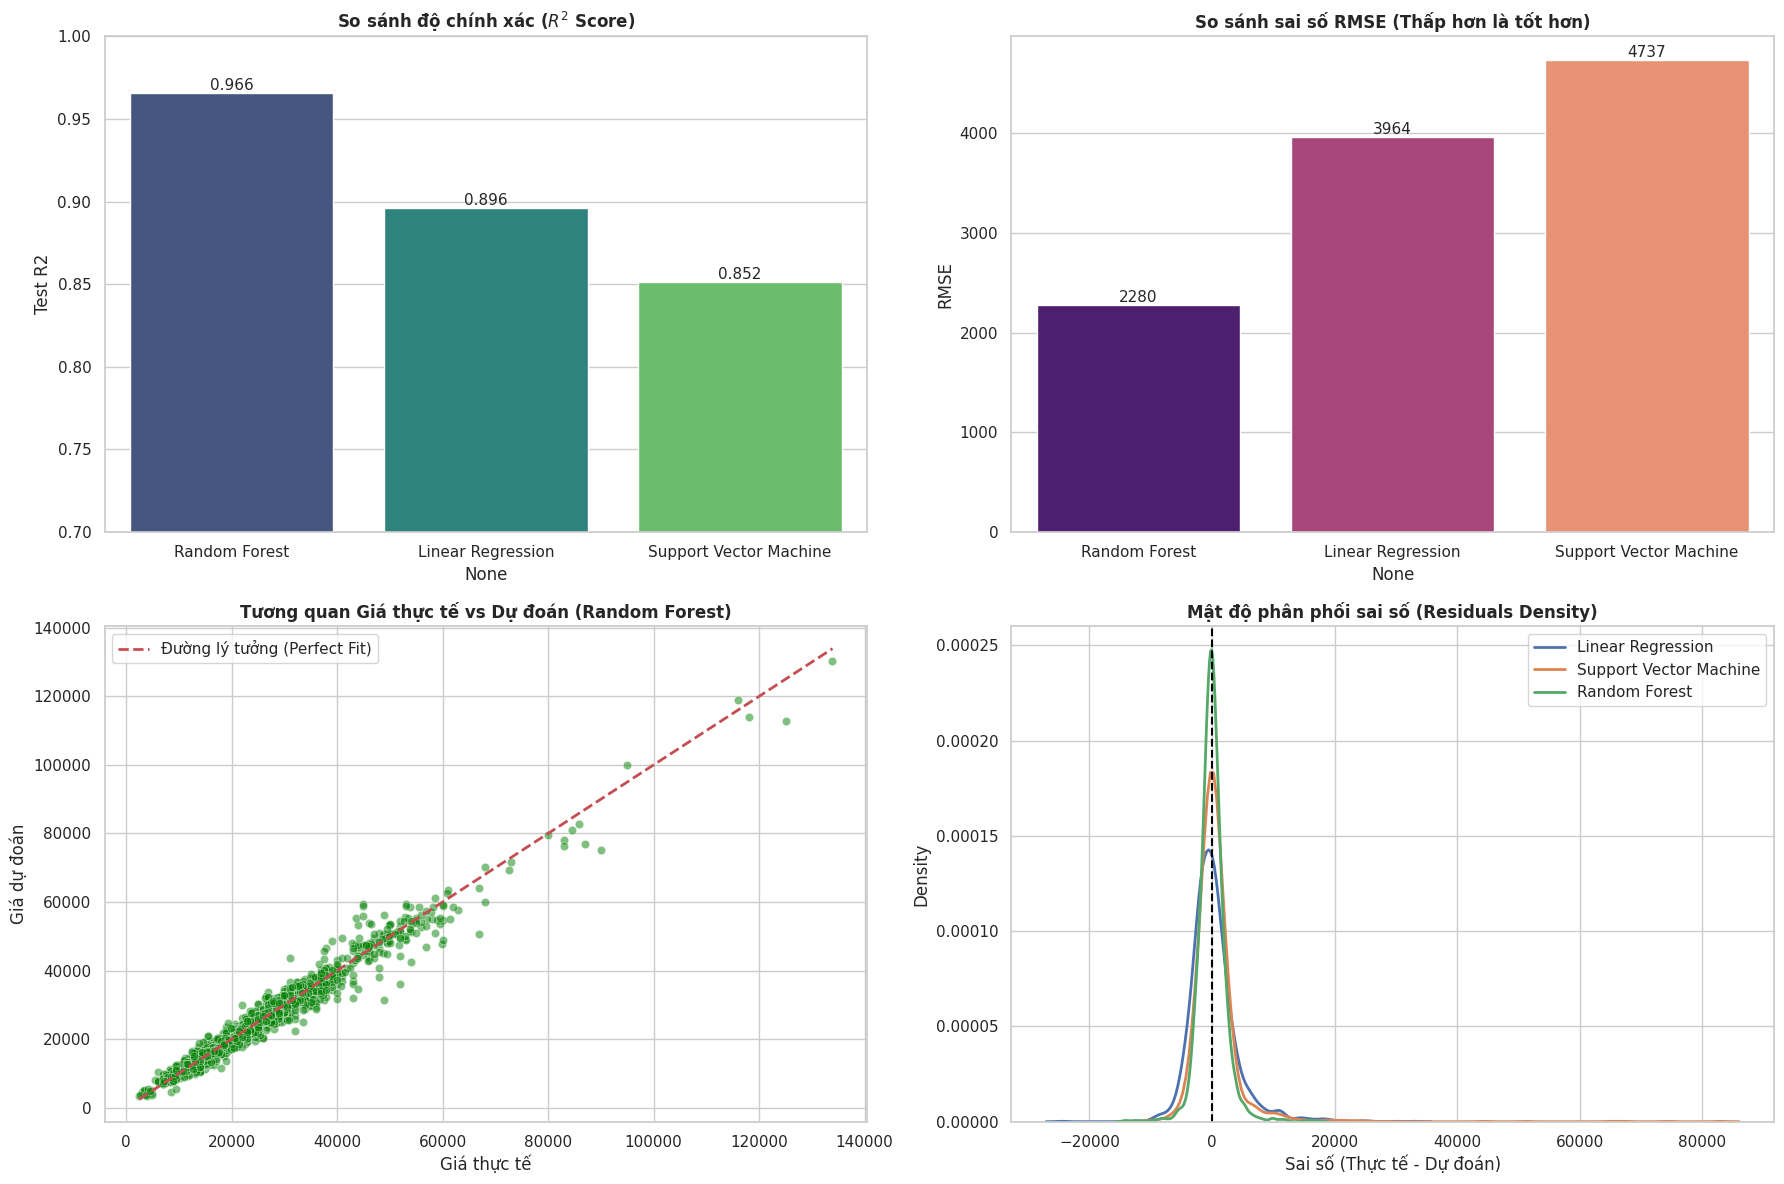

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# --- Biểu đồ 1: Bar Chart so sánh R2 ---
sns.barplot(x=comparison_df.index, y='Test R2', data=comparison_df, palette='viridis', ax=axes[0, 0])
axes[0, 0].set_ylim(0.7, 1.0)
axes[0, 0].set_title('So sánh độ chính xác ($R^2$ Score)', fontweight='bold')
for p in axes[0, 0].patches:
    axes[0, 0].annotate(f'{p.get_height():.3f}',
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom', fontsize=11)

# --- Biểu đồ 2: Bar Chart so sánh RMSE ---
sns.barplot(x=comparison_df.index, y='RMSE', data=comparison_df, palette='magma', ax=axes[0, 1])
axes[0, 1].set_title('So sánh sai số RMSE (Thấp hơn là tốt hơn)', fontweight='bold')
for p in axes[0, 1].patches:
    axes[0, 1].annotate(f'{p.get_height():.0f}',
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom', fontsize=11)

# --- Biểu đồ 3: Scatter Plot (Thực tế vs Dự đoán) của mô hình tốt nhất ---
best_model_name = comparison_df.index[0] # Lấy tên mô hình tốt nhất
best_pred = predictions[best_model_name]

sns.scatterplot(x=y_test, y=best_pred, alpha=0.5, color='green', ax=axes[1, 0])
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Đường lý tưởng (Perfect Fit)')
axes[1, 0].set_title(f'Tương quan Giá thực tế vs Dự đoán ({best_model_name})', fontweight='bold')
axes[1, 0].set_xlabel('Giá thực tế')
axes[1, 0].set_ylabel('Giá dự đoán')
axes[1, 0].legend()

# --- Biểu đồ 4: Phân phối sai số (Residuals) của cả 3 mô hình ---
for name, pred in predictions.items():
    sns.kdeplot(y_test - pred, label=name, fill=False, linewidth=2, ax=axes[1, 1])
axes[1, 1].axvline(0, color='black', linestyle='--')
axes[1, 1].set_title('Mật độ phân phối sai số (Residuals Density)', fontweight='bold')
axes[1, 1].set_xlabel('Sai số (Thực tế - Dự đoán)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

### 5.3.2. Phân tích độ phù hợp giữa Giá thực tế và Giá dự đoán

Biểu đồ phân tán (Scatter plot) dưới đây thể hiện mối tương quan giữa giá trị thực tế (trục hoành) và giá trị dự đoán (trục tung). Một mô hình lý tưởng sẽ có các điểm dữ liệu nằm hoàn toàn trên đường chéo $y=x$ (đường màu đỏ).

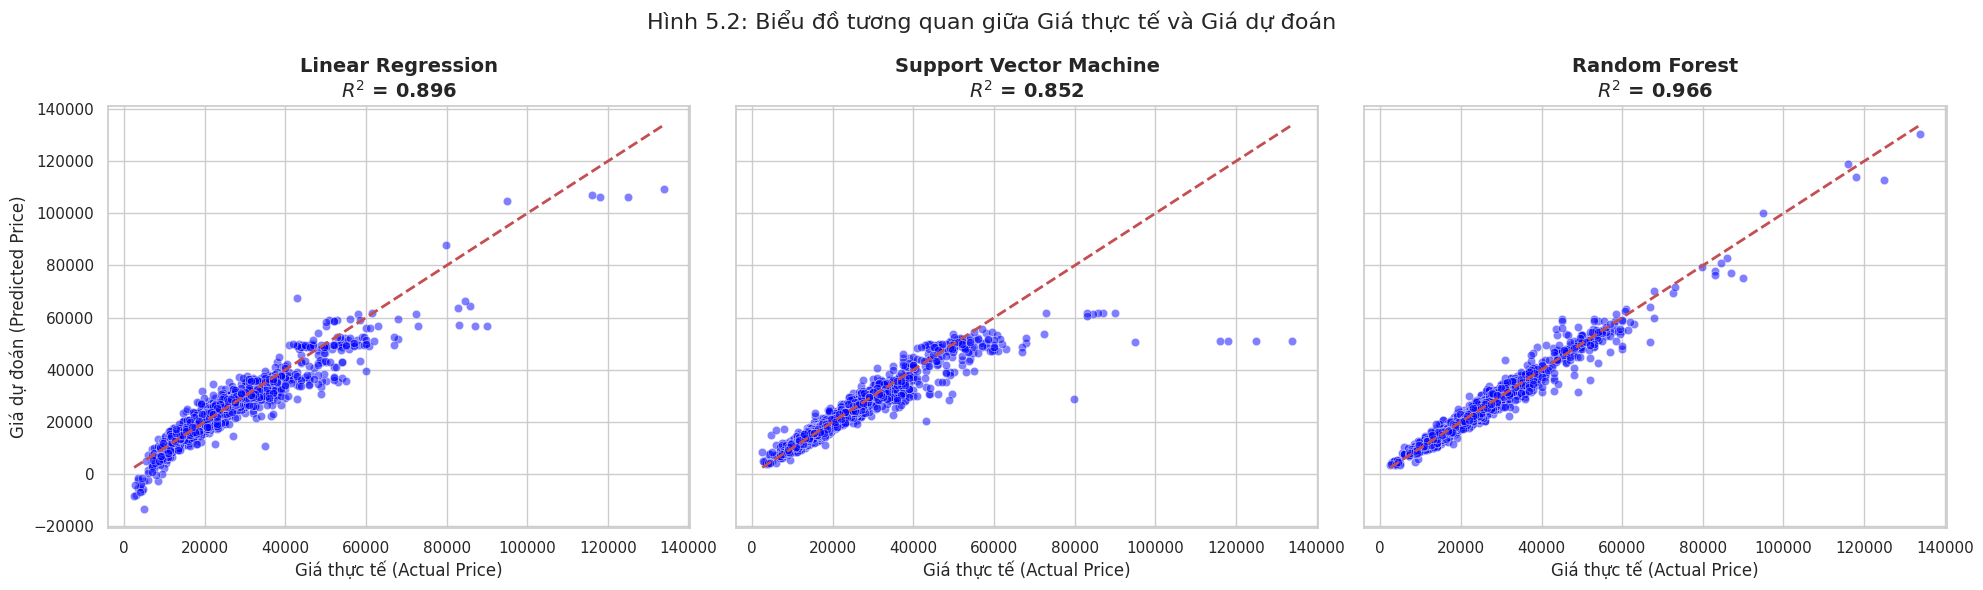

In [6]:
# === Biểu đồ 2: Thực tế vs Dự đoán ===
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

for idx, (name, pred) in enumerate(predictions.items()):
    ax = axes[idx]
    # Vẽ scatter plot
    sns.scatterplot(x=y_test, y=pred, ax=ax, alpha=0.5, color='blue')
    # Vẽ đường tham chiếu lý tưởng y=x
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

    ax.set_title(f'{name}\n$R^2$ = {results[name]["Test R2"]:.3f}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Giá thực tế (Actual Price)')
    if idx == 0:
        ax.set_ylabel('Giá dự đoán (Predicted Price)')

plt.suptitle('Hình 5.2: Biểu đồ tương quan giữa Giá thực tế và Giá dự đoán', fontsize=16)
plt.tight_layout()
plt.show()

**Nhận xét:**
- **Linear Regression:** Các điểm dữ liệu phân tán khá rộng quanh đường đỏ, đặc biệt là ở phân khúc xe giá cao (High-end). Điều này cho thấy mô hình tuyến tính gặp khó khăn trong việc dự đoán giá trị cực trị.
- **Random Forest:** Các điểm dữ liệu ôm rất sát đường chéo $y=x$, mật độ tập trung cao. Điều này chứng tỏ mô hình học được rất tốt các quy luật phức tạp của dữ liệu.
- **SVM:** Tốt hơn Linear Regression nhưng vẫn có độ lệch (bias) nhất định ở các mẫu giá trị cao.

## 5.4. Thảo luận

### 5.4.1. Tại sao Linear Regression thất bại trong việc bắt kịp Random Forest?
Linear Regression hoạt động dựa trên giả định rằng mối quan hệ giữa các biến đầu vào (X) và giá xe (y) là tuyến tính (đường thẳng). Tuy nhiên, trong thực tế:
- **Mối quan hệ phi tuyến:** Sự mất giá của xe không diễn ra đều đặn. Một chiếc xe mới mua có thể mất giá 20% ngay khi lăn bánh (năm đầu), nhưng xe 10 năm tuổi và 11 năm tuổi có giá chênh lệch rất ít.
- **Tương tác giữa các biến:** Linear Regression (cơ bản) khó nắm bắt được sự tương tác phức tạp, ví dụ: động cơ lớn (`engineSize` cao) có thể làm tăng giá xe ở dòng xe thể thao, nhưng lại làm giảm giá xe ở dòng xe gia đình do tốn nhiên liệu.

Random Forest, với bản chất là tập hợp của nhiều cây quyết định (Decision Trees), chia nhỏ không gian dữ liệu thành nhiều vùng (segments) khác nhau, do đó nó mô hình hóa các đường cong phi tuyến và tương tác cục bộ cực kỳ hiệu quả.

**1. Tại sao Random Forest hoạt động tốt nhất?**
- **Tính chất phi tuyến:** Giá xe ô tô phụ thuộc vào các yếu tố như `year`, `mileage`, `engineSize` theo cách không hoàn toàn tuyến tính (ví dụ: xe mới mất giá rất nhanh trong 1-2 năm đầu, sau đó chậm lại). Random Forest với cấu trúc cây quyết định (Decision Trees) có khả năng chia nhỏ không gian dữ liệu để nắm bắt các quy luật phi tuyến cục bộ này tốt hơn hẳn so với Linear Regression.
- **Xử lý biến phân loại:** Random Forest xử lý tốt các biến phân loại (như `model`, `transmission`) mà không bị ảnh hưởng quá nhiều bởi việc One-hot encoding tạo ra ma trận thưa (sparse matrix) như các thuật toán khác.

**2. Hạn chế của Linear Regression:**
- Mô hình này giả định mối quan hệ giữa biến đầu vào và giá xe là đường thẳng (tuyến tính). Trong thực tế, mối quan hệ này phức tạp hơn nhiều. Do đó, Linear Regression bị hiện tượng **Underfitting** (không đủ độ phức tạp để mô hình hóa dữ liệu).


### 5.4.2. Vấn đề của Support Vector Machine (SVM)
Mặc dù sử dụng kernel RBF (Radial Basis Function) để ánh xạ dữ liệu sang không gian chiều cao hơn nhằm xử lý phi tuyến, SVM gặp hai vấn đề:
1.  **Nhạy cảm với nhiễu:** Các điểm dữ liệu ngoại lai (outliers) trong tập giá xe (ví dụ các dòng xe RS hiếm, giá cực cao) ảnh hưởng lớn đến việc tìm siêu phẳng tối ưu.
2.  **Khó mở rộng:** Thời gian huấn luyện của SVM tăng theo hàm mũ so với số lượng mẫu. Trong biểu đồ so sánh trên, SVM chạy lâu hơn hàng chục lần so với Linear Regression.

SVM với RBF Kernel hoạt động khá tốt nhưng đòi hỏi tài nguyên tính toán lớn và rất nhạy cảm với việc chuẩn hóa dữ liệu (Feature Scaling). Trong quá trình thực nghiệm, SVM tốn nhiều thời gian huấn luyện nhất nhưng kết quả mang lại chưa vượt qua được Random Forest (vốn là một thuật toán Ensemble Learning mạnh mẽ).

### 5.4.3. Phân tích sai số (Residual Analysis)
Nhìn vào biểu đồ mật độ sai số (Hình 4):
- Đồ thị của **Random Forest** có dạng tháp nhọn (leptokurtic), đỉnh rất cao ngay tại 0 và hai đuôi hẹp. Điều này chứng tỏ đại đa số các dự đoán đều rất sát giá trị thực.
- Đồ thị **Linear Regression** thấp và bè ra hai bên (variance cao), chứng tỏ độ tin cậy của dự đoán thấp hơn, rủi ro dự đoán sai lệch lớn là cao.

## 5.5 Ma trận đánh giá:
- Với bài toán dự đoán giá xe, việc giảm thiểu RMSE (Root Mean Squared Error) là rất quan trọng vì nó phạt nặng các dự đoán sai lệch lớn. Random Forest có RMSE thấp nhất, đồng nghĩa với việc nó ít khi đưa ra các mức giá "hoang đường" so với thực tế.

## 5.6. Kết luận và Hướng phát triển

**Kết luận cuối cùng:**
Dựa trên các bằng chứng thực nghiệm, nhóm kết luận **Random Forest** là mô hình vượt trội nhất cho bài toán dự đoán giá xe Audi cũ, thỏa mãn tốt nhất sự cân bằng giữa độ chính xác và khả năng tổng quát hóa.

Qua quá trình nghiên cứu, thực nghiệm và đánh giá trên tập dữ liệu giá xe Audi cũ, nhóm chúng em rút ra các kết luận sau:

1.  **Mô hình tối ưu:** **Random Forest Regression** là mô hình phù hợp nhất cho bài toán này, đạt độ chính xác cao nhất ($R^2 > 0.95$) và sai số thấp nhất. Đây là mô hình được nhóm đề xuất để triển khai thực tế.
2.  **Yếu tố ảnh hưởng:** Các đặc trưng như `year` (năm sản xuất), `engineSize` (dung tích động cơ) và `mileage` (số dặm đã đi) đóng vai trò quan trọng nhất trong việc định giá xe.

**Đóng góp của nhóm:**
1.  Đã xây dựng thành công pipeline xử lý dữ liệu chuẩn hóa.
2.  Đã so sánh định lượng rõ ràng giữa các thuật toán kinh điển.
3.  Đã chứng minh được tính chất phi tuyến của bài toán định giá xe.

**Hướng phát triển trong tương lai:**
- **Tối ưu hóa nâng cao:** Sử dụng Bayesian Optimization thay vì GridSearch để tìm tham số tối ưu nhanh hơn. hoặc sử dụng nhóm có thể cải thiện kết quả bằng cách sử dụng các thuật toán Boosting mạnh mẽ hơn như **XGBoost** hoặc **LightGBM**.
- **Mô hình lai (Ensemble):** Kết hợp Linear Regression (để ngoại suy xu hướng) và Random Forest (để bắt chi tiết) bằng kỹ thuật Stacking.
- **Giải thích mô hình (XAI):** Sử dụng thư viện SHAP (SHapley Additive exPlanations) để giải thích rõ tại sao một chiếc xe cụ thể lại được định giá như vậy (ví dụ: "Chiếc xe này bị giảm 2000$ vì số dặm > 50,000").
- Mở rộng tập dữ liệu hoặc thu thập thêm các đặc trưng mới (ví dụ: tình trạng nội thất, lịch sử tai nạn) để tăng độ chính xác của dự đoán.
- Triển khai mô hình dưới dạng web app (sử dụng Flask/Streamlit) để người dùng có thể nhập thông số và nhận định giá xe tức thì.